In [ ]:
!pip install --upgrade --quiet networkx

In [243]:
import numpy as np
import seaborn as sns
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import statsmodels.api as sm
from collections import deque
from sklearn.preprocessing import scale

plt.rcParams['figure.figsize'] = [14, 7]

In [282]:
def partial_correlation(d, i, j):
    """ Estimate partial correlation between i and j """
    cov = np.cov(d.T)
    s = np.sqrt(np.diag(cov))
    corr = cov / np.outer(s,s)
    om = np.linalg.inv(corr)
    return - om[i,j] / np.sqrt(om[i,i] * om[j,j])

def partial_correlation_ols(d, i, j, z):
    """ Estimate partial correlation between i and j conditional on z"""
    fit = lambda i: sm.OLS(data[:, [i]], data[:, z]).fit()
    return np.corrcoef(fit(i).resid, fit(j).resid)[0,1]

def plot_dag(dag, layout = nx.kamada_kawai_layout):
    """ Plots our DAGs with edge weights and labels """
    graph = nx.from_numpy_array(np.abs(dag.adjacency), create_using = nx.DiGraph)
    pos = layout(graph)
    weights = [d['weight'] for i,j,d in graph.edges.data()]
    edges = nx.draw_networkx_edges(graph, pos, edge_cmap = plt.cm.Blues, edge_color = weights)
    labels = nx.draw_networkx_labels(graph, pos)
    nodes = nx.draw_networkx_nodes(graph, pos, with_labels = True)

    pc = matplotlib.collections.PatchCollection(edges, cmap=plt.cm.Blues)
    pc.set_array(weights)
    plt.colorbar(pc)

In [429]:
class DAG():
    def __init__(self, tot, avg_children = 3, noise = .5):
        self.noise = noise
        self.lam = avg_children
        self.i = 0
        self.sorted_adjacency = np.zeros((tot,tot))
        self.new_children = deque([0])
        self.tot = tot
        self.nodes = False

    def _shuffle(self, a):
        n = a.shape[0]
        self.idx = np.random.choice(range(n), size = n, replace=False)
        return a[self.idx].T[self.idx].T
    
    def generate_nodes(self):
        """ Implements a breadth-first generation of nodes """
        while self.new_children:
            i = self.new_children.pop()
            left = self.tot - self.i            
            children = np.random.poisson(self.lam, 1)[0]            
            children = children if left - children >= 0 else left
            connections = [self.i + i for i in range(children)]
            
            # Generates random normal 0,1 edges
            self.sorted_adjacency[i, connections] = np.random.normal(0, 1, children)
            self.i += children
            for c in connections:
                self.new_children.appendleft(c)
            

        # Retry if we did not get a full graph
        if self.i != self.tot:
            self.__init__(self.tot)
            self.generate_nodes()
        
        # Shuffle to get random indices
        self.adjacency = self._shuffle(self.sorted_adjacency)
        self.nodes = True

    def _data(self, n):
        self.data = np.zeros((n,self.tot))
        for i,col in enumerate(self.sorted_adjacency.T):
            dat = self.data.dot(col)
            if np.all(dat == 0):
                dat = np.random.normal(0,1,n)
            self.data[:,i] = dat + np.random.normal(0,self.noise,n)
        return self.data
    
    def generate_data(self, n):
        """ Generates data according to the implied adjacency matrix

        Every node is their parent, times the coefficient in the
        adjacency matrix, plus additive gaussian noise (sd = self.noise).
        """

        if not self.nodes:
            self.generate_nodes()
        dat = self._data(n)
        return dat.T[self.idx].T

In [430]:
dag = DAG(30, noise=.2)

In [446]:
data = dag.generate_data(100)

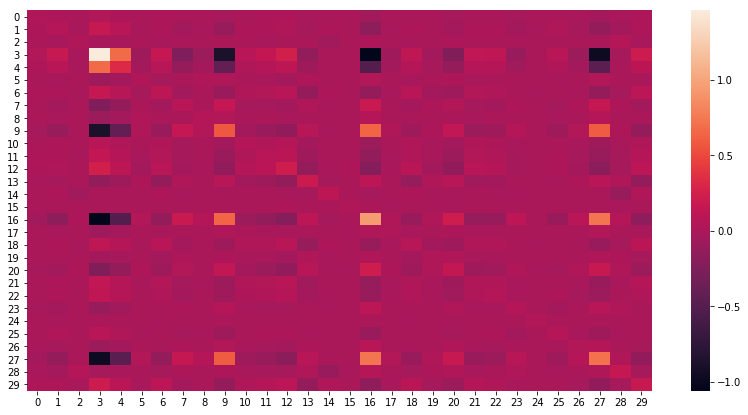

In [447]:
sns.heatmap(np.cov(data.T))

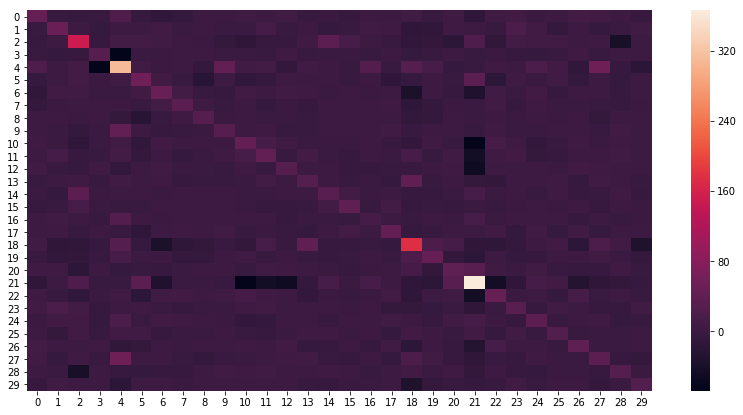

In [448]:
sns.heatmap(np.linalg.inv((np.cov(data.T))))

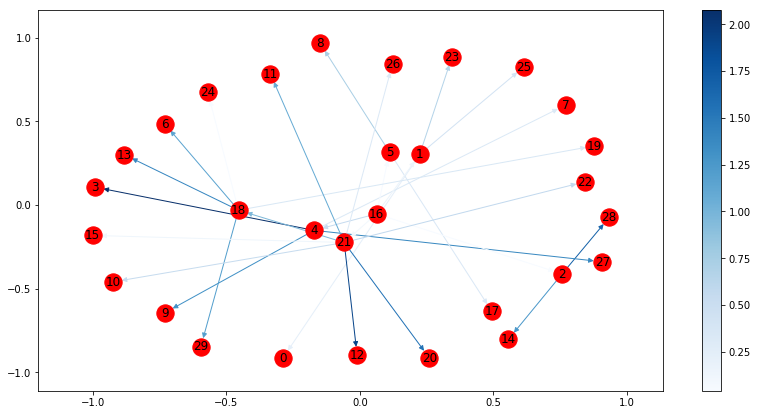

In [445]:
plot_dag(dag, layout = nx.spring_layout)

In [ ]:
# Pick a target variable (y) by looking at the above plot.
# Let the rest of the data be potential predictors

def pick(d, i):
    return d[:, i], np.delete(d, i, 1)

y, X = pick(scale(data), 4)

In [ ]:
# Take a look at the results from OLS. 
# 1. Are they reasonable? 
# 2. Are there any spurious correlations? 

print(sm.OLS(y, X).fit().summary())

In [ ]:
# Given your perfect knowledge of the true DGP,
# pick a reduced form model and run OLS regression. 
# 1. Does this look like a better model? 

In [ ]:
# Clearly, we have a large graph, but we're only interested in 
# the part that is local to our target variable (y).
# Try to find this minimal model via model selection,
# over local linear models: 

In [ ]:
# Take a look at partial correlations between a pair of data points.
# See how this evolves as N (number of observations) grows.

In [ ]:
# Now let's try to recover the ENTIRE precision matrix, 
# via a series of local regressions